### 1. Φόρτωση και Προετοιμασία Δεδομένων
- Καθορίζονται τα paths για τα train/test δεδομένα από το dataset `chest_xray`.
- Χρησιμοποιείται `ImageDataGenerator` για:
  - **Κανονικοποίηση** των pixel values (rescale).
  - **Data augmentation** (μόνο στο training set): περιστροφή, zoom, οριζόντια αναστροφή.
  - **Split**: το 10% των training δεδομένων κρατείται ως validation set.
- Δημιουργούνται οι generators `train_generator`, `val_generator`, `test_generator`.

### 2. Υπολογισμός Class Weights
- Χρησιμοποιείται `compute_class_weight()` για να αντιμετωπιστεί η **ανισορροπία κλάσεων** (Normal vs Pneumonia).
- Δημιουργείται λεξικό `class_weights_dict` που χρησιμοποιείται στην εκπαίδευση.

### 3. Ορισμός Μοντέλου με Hyperparameter Tuning
- Χρησιμοποιείται το εργαλείο
  **Keras Tuner** για αυτόματο πειραματισμό με:
  - Αριθμό φίλτρων στα `Conv2D` layers.
  - Μέγεθος του `Dense` layer.
  - Ποσοστό `Dropout`.
  - Τιμή `learning_rate`.
- Το μοντέλο είναι `Sequential` και καταλήγει σε `sigmoid` για binary classification.

### 4. Εκτέλεση Hyperparameter Search
- Ορίζεται `kt.RandomSearch` με `max_trials=5` για να δοκιμαστούν 5 παραλλαγές του μοντέλου.
- Εκπαίδευση κάθε μοντέλου για 10 εποχές με στόχο την `val_accuracy`.
- Χρησιμοποιείται `EarlyStopping` για να αποφευχθεί overfitting και σπατάλη χρόνου.

### 5. Ανάκτηση Βέλτιστων Υπερπαραμέτρων
- Γίνεται ανάκτηση των καλύτερων υπερπαραμέτρων μέσω `tuner.get_best_hyperparameters()`.
- Εκτυπώνονται οι τιμές για τεκμηρίωση.

### 6. Τελική Εκπαίδευση του Καλύτερου Μοντέλου
- Το καλύτερο μοντέλο (`best_model`) εκπαιδεύεται περαιτέρω για έως 20 εποχές με:
  - `ReduceLROnPlateau`: Μειώνει το learning rate όταν το validation loss σταθεροποιείται.
  - `EarlyStopping`: Σταματά την εκπαίδευση αν δεν υπάρχει βελτίωση, και επαναφέρει τα καλύτερα βάρη (`restore_best_weights=True`).
  - Χρήση `class_weights_dict` για επιπλέον ισορροπία κατά την εκπαίδευση. θα χρειαζόταν για χειροκίνητη ρύθμιση.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20

base_dir = "C:/Users/micha/Downloads/archive (2)/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Ορισμός μοντέλου για Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Δημιουργία tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pneumonia_tuning'
)

# Αναζήτηση καλύτερων hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

# Παίρνουμε το καλύτερο μοντέλο
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

# Μπορείς να εκπαιδεύσεις το καλύτερο μοντέλο για περισσότερα epochs
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2), EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)

Trial 5 Complete [00h 24m 54s]
val_accuracy: 0.9270633459091187

Best val_accuracy So Far: 0.9270633459091187
Total elapsed time: 01h 18m 51s
Best hyperparameters:
{'conv1_filters': 64, 'conv2_filters': 96, 'conv3_filters': 192, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 9.365405773289619e-05}
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9066 - loss: 0.2330 - val_accuracy: 0.9136 - val_loss: 0.2436 - learning_rate: 9.3654e-05
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9232 - loss: 0.2022 - val_accuracy: 0.8829 - val_loss: 0.2809 - learning_rate: 9.3654e-05
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9320 - loss: 0.1762 - val_accuracy: 0.9098 - val_loss: 0.2430 - learning_rate: 9.3654e-05
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9252 - loss: 0.1842 - val_accuracy: 0.8868 - val_loss: 0.2841 - learning_rate: 9.3654e-05
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy

In [4]:
best_model.save("best_pneumonia_model.h5")

In [5]:
from tensorflow.keras.models import load_model
model = load_model("best_pneumonia_model.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step


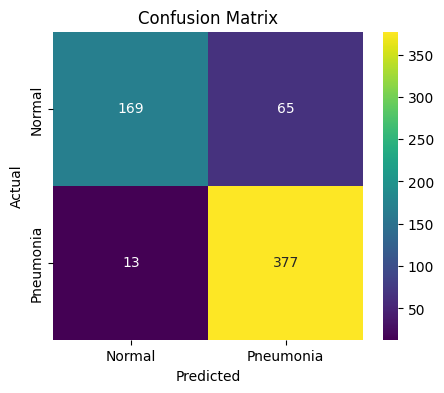

Classification Report:
               precision    recall  f1-score   support

      Normal       0.93      0.72      0.81       234
   Pneumonia       0.85      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.88      0.87       624



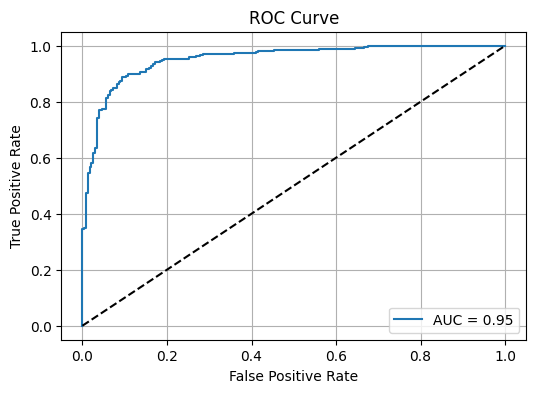

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# Κάνε προβλέψεις
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = (preds > 0.5).astype(int).reshape(-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


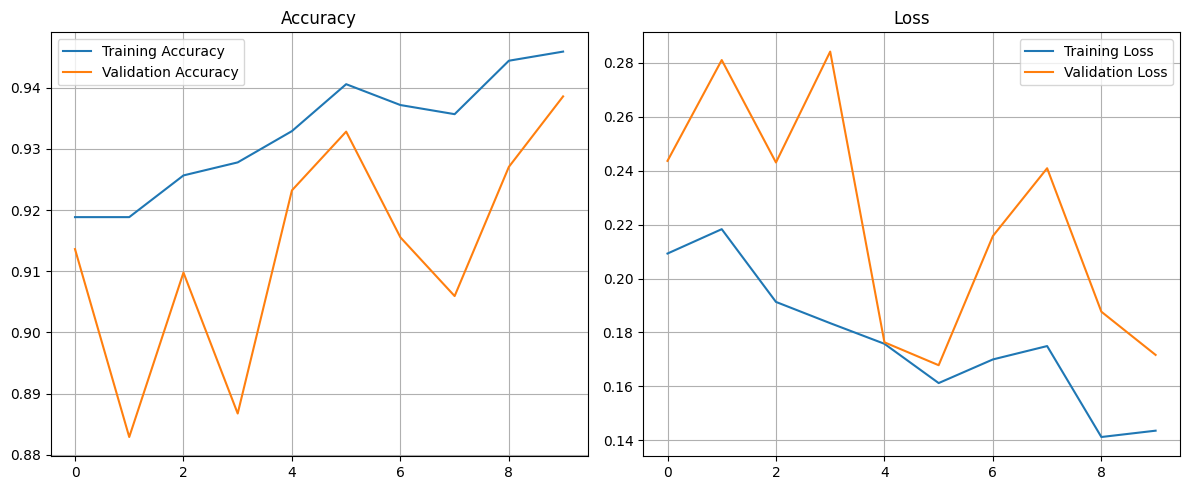

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()


**Παραδείγματα normal and pneumonia** 

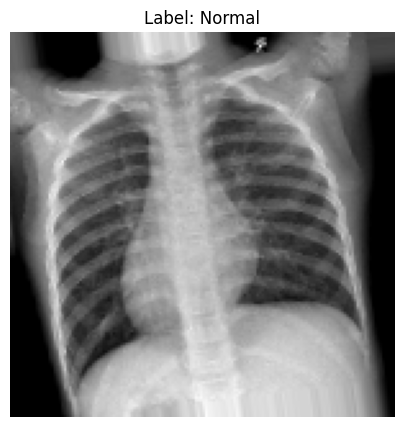

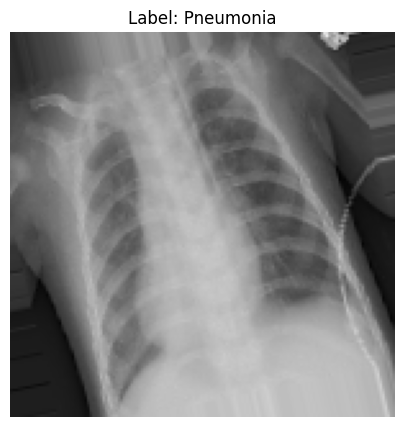

In [24]:
# Παίρνουμε ένα batch από τον train_generator
batch_images, batch_labels = next(train_generator)

# Εντοπίζουμε index για Normal (0) και Pneumonia (1)
normal_idx = np.where(batch_labels == 0)[0][0]
pneumonia_idx = np.where(batch_labels == 1)[0][0]

# Λεζάντες
labels = {0: 'Normal', 1: 'Pneumonia'}

# Εμφάνιση Normal
plt.figure(figsize=(5,5))
plt.imshow(batch_images[normal_idx])
plt.title(f"Label: {labels[0]}")
plt.axis('off')

# Εμφάνιση Pneumonia
plt.figure(figsize=(5,5))
plt.imshow(batch_images[pneumonia_idx])
plt.title(f"Label: {labels[1]}")
plt.axis('off')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step


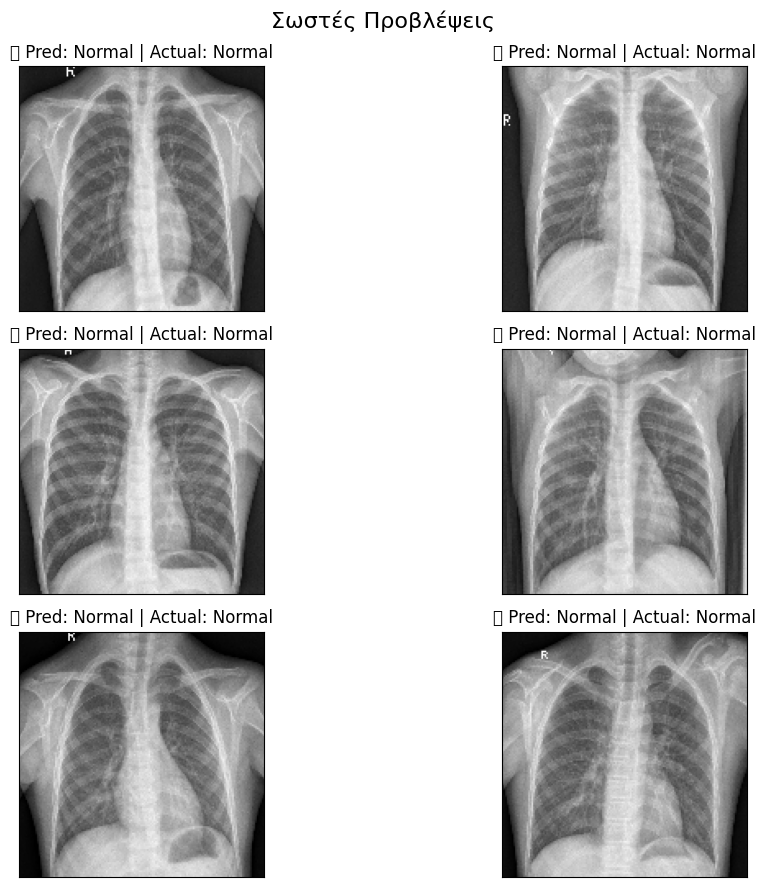

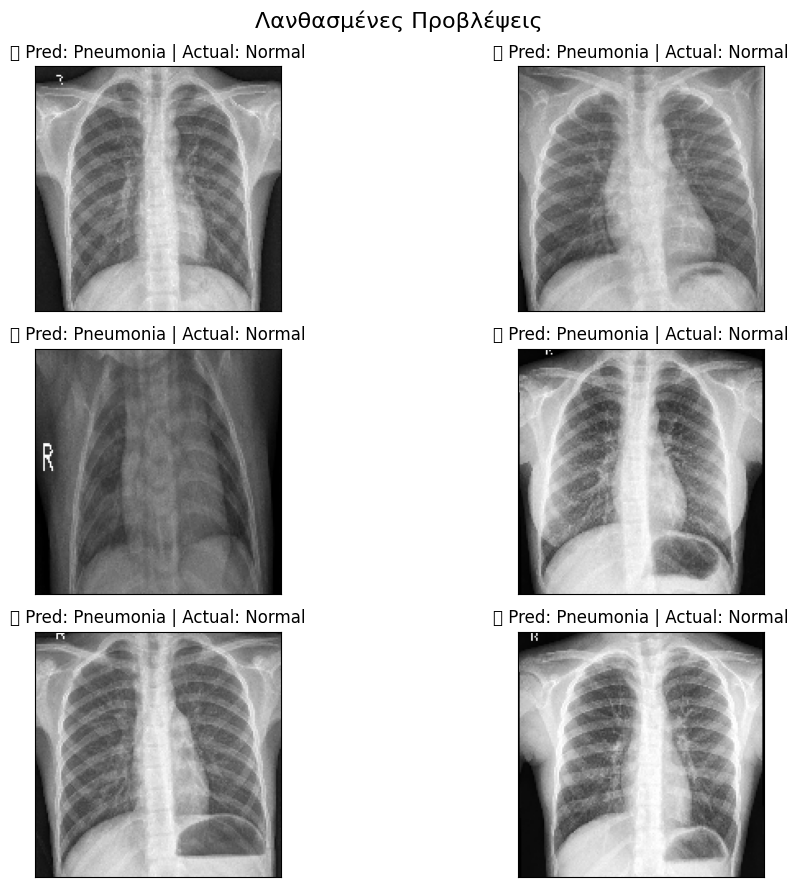

In [25]:
# Βήμα 1: Λήψη εικόνων και labels από τον test_generator
x_test, y_test = [], []

for i in range(len(test_generator)):
    x, y = test_generator[i]
    x_test.extend(x)
    y_test.extend(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Βήμα 2: Προβλέψεις
pred_probs = best_model.predict(x_test)
predictions = (pred_probs > 0.5).astype(int).reshape(-1)

# Βήμα 3: Ευρετήρια σωστών και λάθος
correct = np.where(predictions == y_test)[0]
incorrect = np.where(predictions != y_test)[0]

labels = {0: 'Normal', 1: 'Pneumonia'}

# Βήμα 4: Εμφάνιση 6 σωστών
plt.figure(figsize=(12, 9))
for i, c in enumerate(correct[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"✅ Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Σωστές Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()

# Βήμα 5: Εμφάνιση 6 λανθασμένων
plt.figure(figsize=(12, 9))
for i, c in enumerate(incorrect[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"❌ Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Λανθασμένες Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()


In [27]:
# Αξιολόγηση του καλύτερου μοντέλου στο test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 448ms/step - accuracy: 0.8118 - loss: 0.4798

 Test Accuracy: 87.50%
 Test Loss: 0.3340
